run `ipcluster start` prior to running the notebook if you want parallel functionality.

alternatively, run `ipcluster nbextension enable` to enable the notebook extension

requires `ipyparallel` package (`pip install ipyparallel`)

In [1]:
import ipyparallel as ipp

In [2]:
# import the package functions
from ThinLayer import fkmod as tl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

Loading ThinLayer package


In [3]:
c = ipp.Client()
v=c[:]
path = %pwd
v['path'] = path

# parallel dependencies
with v.sync_imports():
    import numpy
    from numpy.linalg import inv
    import hankel
    from hankel import HankelTransform
    from scipy import special
    import time, sys
    %px sys.path.append(path)
    from ThinLayer import fkmod
    
%px np = numpy
%px scs = special
%px tl = fkmod

importing numpy on engine(s)
importing inv from numpy.linalg on engine(s)
importing hankel on engine(s)
importing HankelTransform from hankel on engine(s)
importing special from scipy on engine(s)
importing time on engine(s)
importing sys on engine(s)
importing InteractiveShell from IPython.core.interactiveshell on engine(s)
importing fkmod from ThinLayer on engine(s)


# Numerical example

Define another dictionary `model` to store the model/modeling parameters: layers, thickness, source and receiver depths, source frequency, frequency and offset vector, number of integration points

Define dictionary `layer` assigning a layer label with fixed, potentially complex elastic constants and density. The elastic constants correspond to an VTI medium and are to be given in order ($c_{11}, c_{13}, c_{33}, c_{44}, \rho$).

In [11]:
layers={
    "layer 1":(22.56, 12.38, 17.35, 3.15, 2.38),
    "layer 2":(26.73, 12.51, 26.73, 7.11, 2.22),
    "layer 3":(11.25, 6.066, 11.25, 2.592, 1.8),
    "layer 4":(11.25 + 1j, 6.066, 26.25, 2.592, 1.8),
    "layer 5":(11.25 + 1j, 2.066, 19.25, 2.592, 1.8),
    "layer 6":(11.25 + 1j, 6.066, 23.25, 2.592, 1.8)
};

model={
    "layers": layers,
    "model_layers": (['layer 2', 'layer 1', 'layer 2']),
    "model_thickness":  [1,.4,1],
    "zSource":.4,
    "zReceiver":.8,
    "srcw": 15,
    "omega": 2*np.pi*np.arange(0.5,50.5,0.5),
    "r": np.arange(0.05,2.05,0.05),
    "nslow": 100
}

## Parallel tests

In [5]:
zSeq, omega, r, elapsed = tl.FKmodeling(model)
print('Sequential time: '+str(elapsed)+' sec')

Sequential time: 8.539693355560303 sec


In [6]:
zPar, _, _, elapsed = tl.FKmodeling_par(v, model)
print('Parallel time: '+str(elapsed)+' sec')

Parallel time: 2.301105499267578 sec


## Hankel transfrom test (number of integration points)
*long computations, don't run*

In [5]:
model['nslow'] = 3000
# get reference gather in f-r domain
gatherF, omega, r, elapsed0 = tl.FKmodeling_par(v, model)

# transform the gather into t-r domain
gather0 = np.array([tl.ftot(gatherF[i],omega,model['srcw'])[1] for i in range(len(gatherF))])
taxis = tl.ftot(gatherF[1],omega)[0]

In [6]:
# vector of cases to compare against the reference (3000 pts.)
Npts = np.arange(100,2100,100)

error = []
timevec = []
for i, nslow in enumerate(Npts):
    print('i = '+str(i+1)+' of '+str(len(Npts)))
    model["nslow"] = nslow
    gatherF, _, _, elapsed = tl.FKmodeling_par(v, model)
    timevec.append(elapsed)
    gather = np.array([tl.ftot(gatherF[i],omega,model['srcw'])[1] for i in range(len(gatherF))])
    error.append(np.sum(np.abs(gather - gather0)))
    clear_output(wait = True)

i = 20 of 20


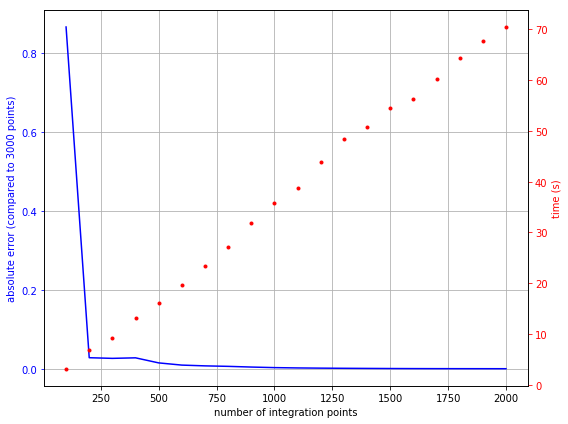

In [7]:
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.plot(Npts, error, 'b-')
ax1.set_ylabel('absolute error (compared to 3000 points)', color='b')
ax1.set_xlabel('number of integration points')
ax1.tick_params('y', colors='b')
ax1.grid(True)
ax2 = ax1.twinx()
ax2.plot(Npts, timevec, 'r.')
ax2.set_ylabel('time (s)', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

## Hankel transfrom test (number of layers)
*long computations, don't run*

In [8]:
Ncases = 12
model['nslow'] = 100
model['model_layers'] = ['layer 2', 'layer 1']
model['model_thickness'] = [1,1]

timevec = []
gathers = []
for i in range(Ncases):
    if i % 2 ==0:
        model['model_layers'].append('layer 2')
    else:
        model['model_layers'].append('layer 1')
    print('i = '+str(i+1)+' of '+str(Ncases))
    model['model_thickness'].insert(-1,0.1 + 0.1 *np.random.random())
        
    gatherF, omega, r, elapsed = tl.FKmodeling_par(v, model)
    timevec.append(elapsed)
    gather = np.array([tl.ftot(gatherF[i],omega,model['srcw'])[1] for i in range(len(gatherF))])
    gathers.append(gather)
    clear_output(wait = True)

i = 12 of 12


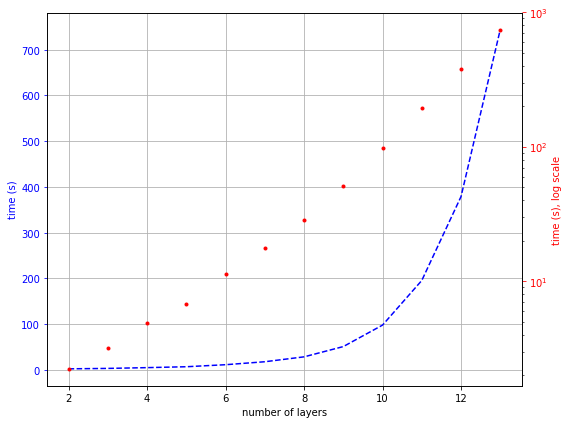

In [9]:
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.plot(np.arange(Ncases)+2, timevec, 'b--')
ax1.set_ylabel('time (s)', color='b')
ax1.set_xlabel('number of layers')
ax1.tick_params('y', colors='b')
ax1.grid(True)
ax2 = ax1.twinx()
ax2.plot(np.arange(Ncases)+2, timevec, 'r.')
ax2.set_ylabel('time (s), log scale', color='r')
ax2.tick_params('y', colors='r')
ax2.set_yscale('log')
fig.tight_layout()
plt.show()

## Some other examples

In [19]:
model['nslow'] = 1000
# get reference gather in f-r domain
gatherF, omega, r, _ = tl.FKmodeling_par(v, model)

# transform the gather into t-r domain
gather = np.array([tl.ftot(gatherF[i],omega,model['srcw'])[1] for i in range(len(gatherF))])
taxis = tl.ftot(gatherF[1],omega)[0]

(1, 0)

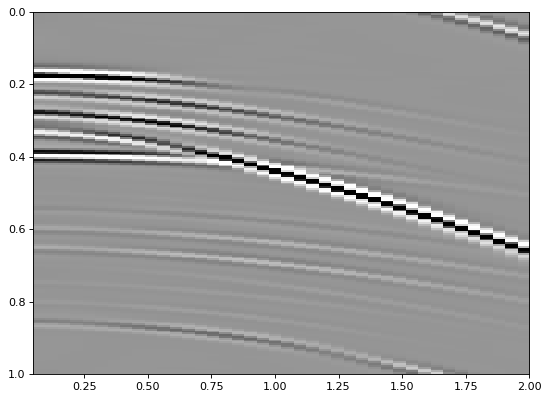

In [20]:
drange = [np.amin(r), np.amax(r), np.amax(taxis), np.amin(taxis)];
vm = np.percentile(gather, 99)

plt.figure(figsize=(8, 6), dpi= 80)
plt.imshow(gather.T, cmap="Greys", vmin=-vm, vmax=vm, aspect='auto', extent=drange)
plt.ylim([1,0])